# A keras model

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(123)

from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Reshape
from keras.layers.recurrent import LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.layers.wrappers import TimeDistributed
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import model_from_yaml
from tqdm import tqdm

from preprocess import *
from util import *

Using Theano backend.


In [3]:
#TODO: shift data down to 0-89 instead of 19-...
NUM_POSSIBLE_ACTIONS = len(pitchToTuple(SILENCE, ambitus=(HIGHEST_PITCH-LOWEST_PITCH)*2))
EMBEDDING_DIMENSIONS=10
#MIN_SONG_LENGTH=200 #TODO figure out/look up

In [4]:
NUM_SONGS = 900

sop = useNumberHolds(loadData('Soprano')[:NUM_SONGS])
min_song_length = min(len(song) for song in sop) // 4 * 4 #trim to last measure
data = np.array([song[:min_song_length] for song in sop])



def categorical(string):
    bass = useNumberHolds(loadData(string)[:NUM_SONGS])
    trimmed_categorical_bass = [to_categorical(np.array(song[:min_song_length])-LOWEST_PITCH, nb_classes=NUM_POSSIBLE_ACTIONS) for song in bass]
    labels = np.array(trimmed_categorical_bass)
    return labels

labels_bass = categorical('Bass')
labels_tenor = categorical('Tenor')
labels_alto = categorical('Alto')

In [5]:
data.shape

(900, 80)

In [6]:
model = Sequential()

model.add(Embedding(NUM_POSSIBLE_ACTIONS, EMBEDDING_DIMENSIONS, input_length=min_song_length))

model.add(LSTM(EMBEDDING_DIMENSIONS, return_sequences=True))
model.add(LSTM(EMBEDDING_DIMENSIONS, return_sequences=True))
model.add(LSTM(EMBEDDING_DIMENSIONS, return_sequences=True))
model.add(LSTM(EMBEDDING_DIMENSIONS, return_sequences=True))
print(model.output_shape)

#model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(NUM_POSSIBLE_ACTIONS*3)))
print(model.output_shape)
model.add(Reshape((min_song_length*3, NUM_POSSIBLE_ACTIONS)))
#model.add(TimeDistributed(Reshape((NUM_POSSIBLE_ACTIONS,3))))
model.add(Activation('softmax'))
model.add(Reshape((min_song_length, NUM_POSSIBLE_ACTIONS*3)))
print(model.output_shape)


model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])




#Now: 80x100 -> 80x178
#Want: 3x80x100 -> 3x80x178
#Approach: 80x300 -> reshape 240x100 -> 240x178 -> 3x80x178

(None, 80, 10)
(None, 80, 534)
(None, 80, 534)


In [11]:
labels = np.concatenate((labels_bass, labels_alto, labels_tenor), axis=2)
model.fit(data, labels, nb_epoch=10, batch_size=32)

In [22]:
import util
import imp; imp.reload(util)

melody_num = 0

#output = model.predict(data[melody_num, np.newaxis])
bass_output = labels[0] [:,:NUM_POSSIBLE_ACTIONS]
alto_output = labels[0] [:,NUM_POSSIBLE_ACTIONS:NUM_POSSIBLE_ACTIONS*2]
tenor_output = labels[0] [:,NUM_POSSIBLE_ACTIONS*2:]

bass_pitches = np.array([np.argmax(bass_output[ time, :]) for time in range(bass_output.shape[0])])+LOWEST_PITCH
alto_pitches = np.array([np.argmax(alto_output[ time, :]) for time in range(alto_output.shape[0])])+LOWEST_PITCH
tenor_pitches = np.array([np.argmax(tenor_output[ time, :]) for time in range(tenor_output.shape[0])])+LOWEST_PITCH

bass_stream = util.pitchToStream(bass_pitches)
alto_stream = util.pitchToStream(alto_pitches)
tenor_stream = util.pitchToStream(tenor_pitches)

def get_stream(model):
    print (model)
    output=model.predict(data[melody_num, np.newaxis])
    print(output.shape)
    song_pitches = np.array([np.argmax(output[0, time, :]) for time in range(output.shape[1])])+LOWEST_PITCH
    print(song_pitches)
    return util.pitchToStream(song_pitches)

combined = m21.stream.Stream([alto_stream, tenor_stream, bass_stream])

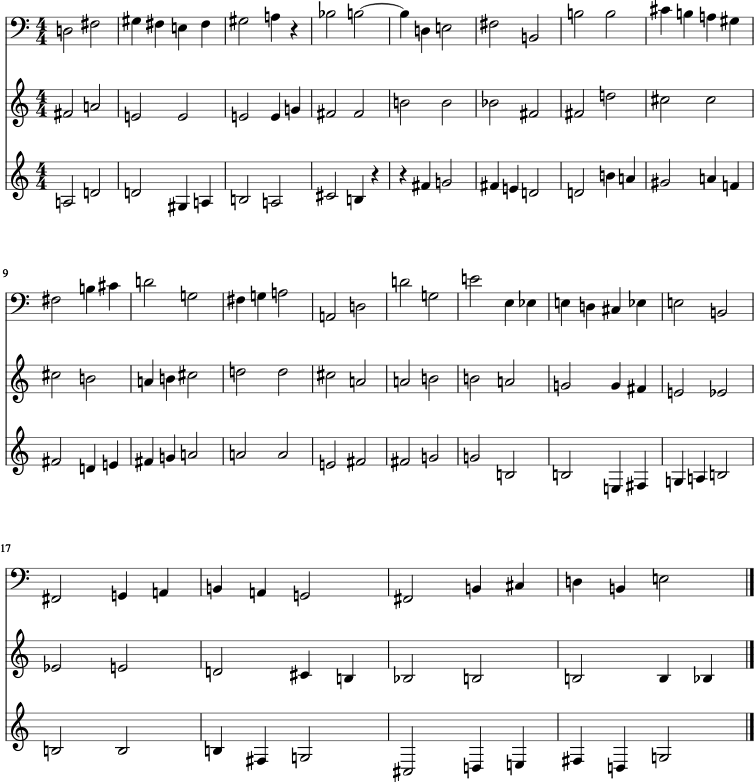

In [21]:
import util
import imp; imp.reload(util)
combined.show()

In [85]:
util.pitchToStream(song_pitches).show('midi')

In [86]:
bass_out = util.pitchToStream(song_pitches)
melody_out = util.pitchToStream(data[melody_num])

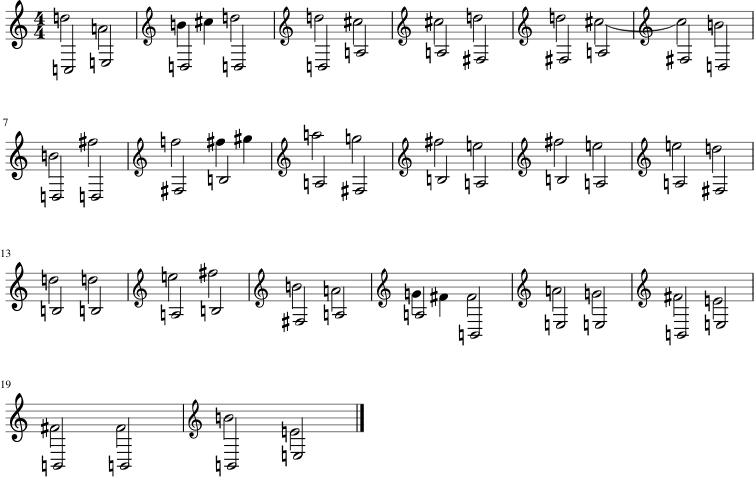

In [87]:
combined = m21.stream.Stream([m21.stream.Voice(bass_out), m21.stream.Voice(melody_out)])
combined.show()

In [88]:
combined.show('midi')

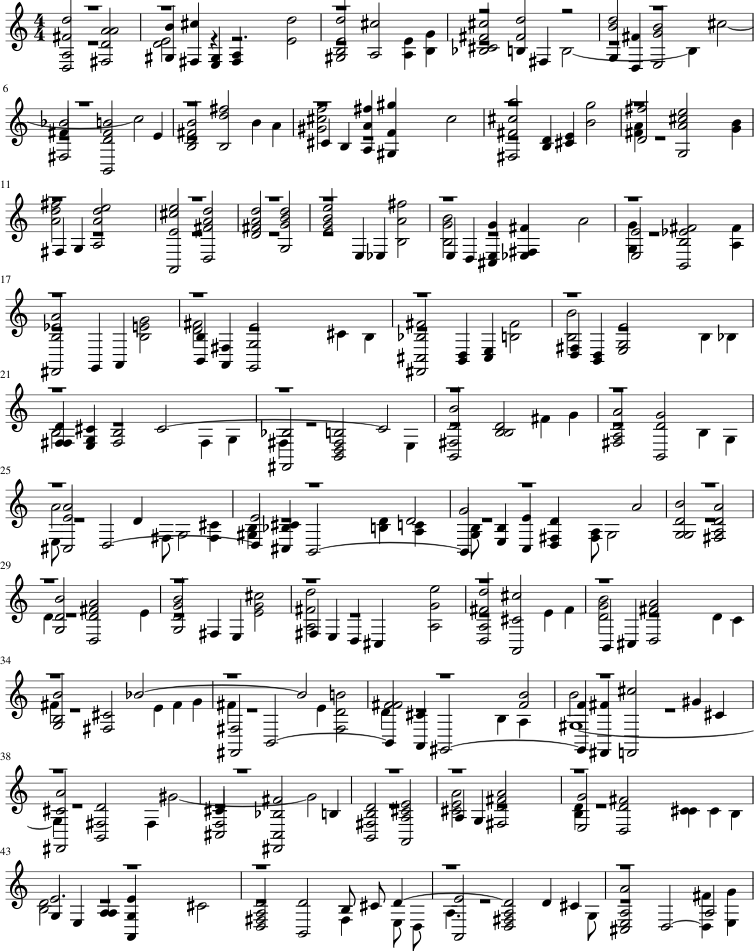

In [82]:
m21.converter.parse('data/bach-chorales/bach-1.mid').show()